In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
import scipy.sparse as sp_sparse
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
aragwas = pd.concat([
    pd.read_csv(
        f"output/aragwas/api_chr{chrom}.csv.gz",
        usecols=["snp.chr", "snp.position", "snp.ref", "snp.alt", "score", "maf", "mac",
                 "study.name", "study.phenotype.name", "overBonferroni", "overPermutation"],
    ).rename(columns={
        "snp.chr": "chrom",
        "snp.position": "pos",
        "snp.ref": "ref",
        "snp.alt": "alt",
        "score": "aragwas_score",
    }) for chrom in ["1", "2", "3", "4", "5"]],
    #axis=1,
    ignore_index=True
)
aragwas.chrom = aragwas.chrom.str.replace("chr", "")
aragwas

,chrom,pos,aragwas_score,maf,mac,study.name,study.phenotype.name,overBonferroni,overPermutation,ref,alt
0,1,16653911,43.734411,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,A,C
1,1,16634821,35.267820,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,G,A
2,1,16634858,35.267820,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,G,A
3,1,16601028,34.882685,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,T,G
4,1,16602311,32.632170,0.047904,24,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,C,T
...,...,...,...,...,...,...,...,...,...,...,...
1225243,5,9055418,4.000051,0.041916,21,"('clim-bio13_raw_Full imputed genotype_amm',)",clim-bio13,False,False,C,T
1225244,5,9056844,4.000051,0.041916,21,"('clim-bio13_raw_Full imputed genotype_amm',)",clim-bio13,False,False,C,T
1225245,5,15646309,4.000035,0.013972,7,"('clim-prec3_raw_Full imputed genotype_amm',)",clim-prec3,False,False,C,T
1225246,5,7726496,4.000002,0.437126,219,"('clim-prec5_raw_Full imputed genotype_amm',)",clim-prec5,False,False,C,A


In [3]:
full_aragwas = aragwas.copy()

In [4]:
aragwas = aragwas.groupby(["chrom", "pos", "ref", "alt"]).agg({
    "aragwas_score": "max", "overBonferroni": "any", "overPermutation": "any",
    "study.phenotype.name": "unique",
}).reset_index()
aragwas

,chrom,pos,ref,alt,aragwas_score,overBonferroni,overPermutation,study.phenotype.name
0,1,221,A,G,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]"
1,1,667,C,T,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]"
2,1,754,C,T,4.653143,False,False,"[clim-gs5, clim-aet12, clim-aet1]"
3,1,774,A,T,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]"
4,1,1089,C,A,4.607782,False,False,"[clim-gs10, clim-bio4, clim-aet6]"
...,...,...,...,...,...,...,...,...
510589,5,26974716,A,G,14.217024,True,True,"[clim-bio4, clim-bio7, clim-gs10, clim-tmin2, ..."
510590,5,26975046,A,G,4.209524,False,False,[Leaf roll 22]
510591,5,26975053,G,A,5.623626,False,False,[ScalingExponent]
510592,5,26975121,G,A,4.691377,False,False,"[deltaRGR P Fe norm on Fe norm, RGR P Fe norm]"


In [5]:
d = Path(f"output/variants/all")

In [6]:
# sgkit has square values, and upper triangular
# vs. others
LD_path = "output/aragwas/LD_100000_0.1.npz"
LD = sp_sparse.load_npz(LD_path)
LD

<510462x510462 sparse matrix of type '<class 'numpy.float32'>'
	with 26273275 stored elements in Compressed Sparse Row format>

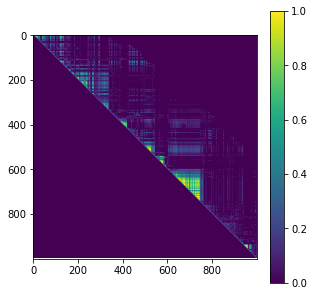

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(LD[:1000, :1000].toarray())
plt.colorbar()

In [8]:
def make_symmetric(A):
    return A + A.T - sp_sparse.diags(A.diagonal())

def sparsify(A, threshold):
    B = A.copy()
    B.data[B.data < threshold] = 0
    B.eliminate_zeros()
    return B


def square(A):
    B = A.copy()
    B.data = np.square(B.data)
    return B

# no need to make symmetric for LD vs. distance


LD = make_symmetric(LD)  # for the ones from sgkit
#LD = square(LD)
LD

<510462x510462 sparse matrix of type '<class 'numpy.float32'>'
	with 52036088 stored elements in Compressed Sparse Row format>

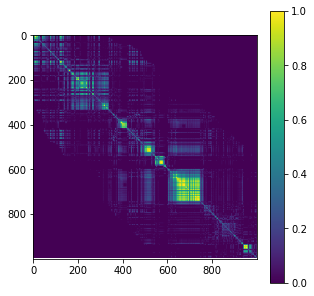

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(LD[:1000, :1000].toarray())
plt.colorbar()

In [60]:
# models with scores defined on all variants
models = [
    "ConvNet_batch2048_weight1.0_secondpart_30k",
    "ConvNet_batch2048_secondpart_30k",
    "ConvNet_batch2048_weight0_secondpart_30k",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000",
    #"phyloP",
    #"phastCons",
]

# models with scores defined on aligned regions
#models_subset = [
#    "ConvNet_batch2048_weight1.0_secondpart_30k",
#    "ConvNet_batch2048_secondpart_30k",
#    "ConvNet_batch2048_weight0_secondpart_30k",
#    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000",
#    "phyloP",
#    "phastCons",
#]
model_renaming = {
    #"ConvNet_batch2048_secondpart_30k": "GPN",
    "ConvNet_batch2048_weight1.0_secondpart_30k": "repeat-weight-1",
    "ConvNet_batch2048_secondpart_30k": "repeat-weight-0.1",
    "ConvNet_batch2048_weight0_secondpart_30k": "repeat-weight-0",
    #"ConvNet_batch2048_secondpart_30k": "8 species",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000": "1 species",
}

variants = pd.read_parquet(d / "variants.parquet")

#for m in models_subset:
for m in models:
    model_path = d / f"{m}.parquet"
    model_name = model_renaming.get(m, m)
    variants[model_name] = pd.read_parquet(model_path)["score"].values
if "phyloP" in models:
    variants["1"] = -np.ones(len(variants))
    models.append("1")
#models_subset.append("1")
models = [model_renaming.get(m, m) for m in models]
#models_subset = [model_renaming.get(m, m) for m in models_subset]
variants = variants.merge(aragwas, how="inner", on=["chrom", "pos", "ref", "alt"], sort=True)
variants["% SNPs are GWAS hits"] = 100 * variants.overPermutation
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
variants["start"] = variants.pos
variants["end"] = variants.start + 1
variants = bf.coverage(variants, repeats).rename(columns={"coverage": "repeat"})
variants.repeat = variants.repeat.astype(bool)
variants

,chrom,pos,ref,alt,AC,AF,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,1 species,aragwas_score,overBonferroni,overPermutation,study.phenotype.name,% SNPs are GWAS hits,start,end,repeat
0,1,667,C,T,17,0.008379,intergenic_variant,0.704838,0.635977,0.613400,0.538185,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]",0,667,668,False
1,1,754,C,T,49,0.024150,intergenic_variant,1.033044,-0.685284,-1.983137,-0.869240,4.653143,False,False,"[clim-gs5, clim-aet12, clim-aet1]",0,754,755,False
2,1,774,A,T,17,0.008379,intergenic_variant,0.417321,0.369063,0.405159,0.190043,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]",0,774,775,False
3,1,1089,C,A,19,0.009364,intergenic_variant,-3.228483,-2.765268,-1.682769,-3.075963,4.607782,False,False,"[clim-gs10, clim-bio4, clim-aet6]",0,1089,1090,True
4,1,1420,T,A,20,0.009857,intergenic_variant,0.075217,-0.115594,-0.009607,-0.670948,4.236610,False,False,[GR21 cold],0,1420,1421,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510457,5,26974716,A,G,63,0.031050,intergenic_variant,-0.996800,-1.170408,-1.256280,-1.027709,14.217024,True,True,"[clim-bio4, clim-bio7, clim-gs10, clim-tmin2, ...",100,26974716,26974717,False
510458,5,26975046,A,G,1701,0.838344,intergenic_variant,-1.056894,-1.260575,-1.238564,-1.251561,4.209524,False,False,[Leaf roll 22],0,26975046,26975047,False
510459,5,26975053,G,A,13,0.006407,intergenic_variant,1.344464,0.812610,0.852425,0.776455,5.623626,False,False,[ScalingExponent],0,26975053,26975054,False
510460,5,26975121,G,A,73,0.035978,intergenic_variant,0.344561,0.303412,0.438019,0.328703,4.691377,False,False,"[deltaRGR P Fe norm on Fe norm, RGR P Fe norm]",0,26975121,26975122,False


In [61]:
if "phyloP" in models:
    variants["phyloP-abs"] = -variants["phyloP"].abs()
    models.append("phyloP-abs")

In [62]:
for m in models:
    if m not in ["1", "phyloP", "phastCons", "phyloP-abs"]:
        variants[m] = -variants[m].abs()

In [63]:
variants[models].isna().mean()

repeat-weight-1      0.0
repeat-weight-0.1    0.0
repeat-weight-0      0.0
1 species            0.0
dtype: float64

In [64]:
# option 1
#variants.loc[:, models] = variants[models].fillna(variants[models].mean())
#variants[models].isna().mean()

In [65]:
# option 2
#not_na = ~variants[models].isna().any(axis=1)
not_na = (~variants[models].isna().any(axis=1)) & (variants.AF < 0.5)
variants = variants[not_na].copy()
idx_not_na = np.where(not_na)[0]
LD2 = LD[idx_not_na][:, idx_not_na]
variants[models].isna().mean()

repeat-weight-1      0.0
repeat-weight-0.1    0.0
repeat-weight-0      0.0
1 species            0.0
dtype: float64

In [66]:
# In case conservation scores are undefined due to lack of alignments
# There are a lot. Should consider doing the plot separately without phyloP
# and phastCons to have full variants? At least for correlation matrix multiplication
# The missingness pattern is very biologically relevant,
# lack of alignment might mean new Arabidopsis-specific region, for example
# GPN OR is actually much higher when including unalignable region
#variants_subset = variants.dropna().copy()
#variants_subset

In [67]:
def LD_profile(LD, score):
    return LD @ score

In [68]:
# very small number of ties (less than 2%), so just taking an arbitrary subset is ok
#(variants_subset[models_subset] <= variants_subset[models_subset].quantile(0.01)).mean()

In [69]:
def binarize(x, q):
    np.random.seed(42)
    res = np.zeros_like(x)
    random_order = np.random.rand(len(x))
    structured_array = np.array(list(zip(x, random_order)), dtype=[('x', x.dtype), ('y', random_order.dtype)])
    bottom_idx = np.argsort(structured_array, order=['x', 'y'])[:int(len(x)*q)]
    res[bottom_idx] = -1.0
    return res


def transform(score, name):
    # option 4
    #return binarize(score, 1e-2)
    
    if name == "1": return score
    
    # option 1: shift
    return score - score.max()

    # option 2: abs (deprecated)
    #return -score.abs()
    
    # option 3: rank transform
    #return -(pd.Series(score).rank(ascending=False)).values


for m in models:
    variants[m] = transform(variants[m], m)
    
#for m in models_subset:
#    variants_subset[m] = transform(variants_subset[m])

In [70]:
(variants[models] == -1).mean()

repeat-weight-1      0.0
repeat-weight-0.1    0.0
repeat-weight-0      0.0
1 species            0.0
dtype: float64

In [71]:
#(variants_subset[models_subset] == -1).mean()

In [72]:
for model in models.copy():
    name = fr"{model}$\times$LD" if model != "1" else "LD Score"
    variants[name] = LD_profile(LD2, variants[model])
    models.append(name)
variants

,chrom,pos,ref,alt,AC,AF,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,...,overPermutation,study.phenotype.name,% SNPs are GWAS hits,start,end,repeat,repeat-weight-1$\times$LD,repeat-weight-0.1$\times$LD,repeat-weight-0$\times$LD,1 species$\times$LD
0,1,667,C,T,17,0.008379,intergenic_variant,-0.704837,-0.635977,-0.613399,...,False,"[clim-gs10, clim-bio4, clim-aet5]",0,667,668,False,-53.557758,-51.811508,-59.724113,-56.046001
1,1,754,C,T,49,0.024150,intergenic_variant,-1.033043,-0.685283,-1.983137,...,False,"[clim-gs5, clim-aet12, clim-aet1]",0,754,755,False,-5.171556,-4.791214,-5.214535,-6.164814
2,1,774,A,T,17,0.008379,intergenic_variant,-0.417320,-0.369062,-0.405159,...,False,"[clim-gs10, clim-bio4, clim-aet5]",0,774,775,False,-53.557758,-51.811508,-59.724113,-56.046001
3,1,1089,C,A,19,0.009364,intergenic_variant,-3.228482,-2.765268,-1.682768,...,False,"[clim-gs10, clim-bio4, clim-aet6]",0,1089,1090,True,-48.684338,-47.018703,-53.853245,-50.859879
4,1,1420,T,A,20,0.009857,intergenic_variant,-0.075216,-0.115593,-0.009606,...,False,[GR21 cold],0,1420,1421,False,-5.845627,-4.623837,-4.420661,-4.462491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510456,5,26974518,T,C,78,0.038443,intergenic_variant,-0.077429,-0.080121,-0.283953,...,False,"[PC2sc0, Mean(LRR) C, Mean(LRR) ABA, Mean(LRD ...",0,26974518,26974519,False,-28.828598,-27.833321,-27.939968,-23.530901
510457,5,26974716,A,G,63,0.031050,intergenic_variant,-0.996799,-1.170407,-1.256279,...,True,"[clim-bio4, clim-bio7, clim-gs10, clim-tmin2, ...",100,26974716,26974717,False,-96.279594,-92.942551,-107.857498,-89.990158
510459,5,26975053,G,A,13,0.006407,intergenic_variant,-1.344463,-0.812610,-0.852425,...,False,[ScalingExponent],0,26975053,26975054,False,-7.112542,-6.919710,-6.074137,-5.503152
510460,5,26975121,G,A,73,0.035978,intergenic_variant,-0.344560,-0.303412,-0.438019,...,False,"[deltaRGR P Fe norm on Fe norm, RGR P Fe norm]",0,26975121,26975122,False,-4.250938,-4.858538,-5.175055,-4.937970


In [73]:
#phylop_idx = np.where(~variants.phyloP.isna().values)[0]
#for model in models_subset.copy():
#    label = fr"{model}$\times$LD"
#    variants_subset[label] = LD_profile(LD[phylop_idx][:, phylop_idx], variants_subset[model])
#    models_subset.append(label)

In [74]:
# cannot flip sign of GPN scores because phyloP and phastCons used the ref and cannot be recomputed
#variants = variants.query("AF < 0.5")
#variants_subset = variants_subset.query("AF < 0.5")
#variants

In [75]:
"""
#variants["bin"] = pd.qcut(variants[r"GPN$\times$LD"], 100, labels=False)
variants["bin"] = pd.cut(variants[r"GPN$\times$LD"], 10).apply(lambda x: x.mid)

plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=variants,
    x="bin",
    y="% SNPs are GWAS hits",
    errorbar=None,
)
#plt.xlabel(r"GPN$\times$LD percentile")
plt.xlabel(r"GPN$\times$LD")
sns.despine();
#plt.savefig("output/plots/ld_profile.svg", bbox_inches='tight');
"""

'\n#variants["bin"] = pd.qcut(variants[r"GPN$\times$LD"], 100, labels=False)\nvariants["bin"] = pd.cut(variants[r"GPN$\times$LD"], 10).apply(lambda x: x.mid)\n\nplt.figure(figsize=(2,2))\ng = sns.lineplot(\n    data=variants,\n    x="bin",\n    y="% SNPs are GWAS hits",\n    errorbar=None,\n)\n#plt.xlabel(r"GPN$\times$LD percentile")\nplt.xlabel(r"GPN$\times$LD")\nsns.despine();\n#plt.savefig("output/plots/ld_profile.svg", bbox_inches=\'tight\');\n'

In [76]:
# variants["bin"].value_counts(sort=False)

In [77]:
ld_models = [m for m in models if "LD" in m]
#ld_models_subset = [m for m in models_subset if "LD" in m]
ld_models#, ld_models_subset

['repeat-weight-1$\\times$LD',
 'repeat-weight-0.1$\\times$LD',
 'repeat-weight-0$\\times$LD',
 '1 species$\\times$LD']

In [78]:
def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df["ModelScoreTier"] = "NA"
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    #df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["overPermutation", "ModelScoreTier"]).size()
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [[False, 'High'],
         [False, 'Low'],
         [True, 'High'],
         [True, 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts

threshold_quantiles = np.linspace(1e-2, 1e-1, 10)
#threshold_quantiles = [1e-3, 1e-2, 1e-1]

rows = []
rows_subset = []

for tq in threshold_quantiles:
    for m in ld_models:
        print(m, tq)
        OR, p_value, min_counts = compute_odds_ratio(variants, tq, m)
        rows.append([m, tq, OR, p_value, min_counts])
    #for m in ld_models_subset:
    #    print(m, tq)
    #    OR, p_value, min_counts = compute_odds_ratio(variants_subset, tq, m)
    #    rows_subset.append([m, tq, OR, p_value, min_counts])
results = pd.DataFrame(rows, columns=["Model", "Threshold quantile", "Odds ratio", "p_value", "min_counts",])
results["significant"] = results.p_value <= 0.05
#results_subset = pd.DataFrame(rows_subset, columns=["Model", "Threshold quantile", "Odds ratio", "p_value", "min_counts",])
#results_subset["significant"] = results_subset.p_value <= 0.05
results

repeat-weight-1$\times$LD 0.01
repeat-weight-0.1$\times$LD 0.01
repeat-weight-0$\times$LD 0.01
1 species$\times$LD 0.01
repeat-weight-1$\times$LD 0.020000000000000004
repeat-weight-0.1$\times$LD 0.020000000000000004
repeat-weight-0$\times$LD 0.020000000000000004
1 species$\times$LD 0.020000000000000004
repeat-weight-1$\times$LD 0.030000000000000006
repeat-weight-0.1$\times$LD 0.030000000000000006
repeat-weight-0$\times$LD 0.030000000000000006
1 species$\times$LD 0.030000000000000006
repeat-weight-1$\times$LD 0.04000000000000001
repeat-weight-0.1$\times$LD 0.04000000000000001
repeat-weight-0$\times$LD 0.04000000000000001
1 species$\times$LD 0.04000000000000001
repeat-weight-1$\times$LD 0.05000000000000001
repeat-weight-0.1$\times$LD 0.05000000000000001
repeat-weight-0$\times$LD 0.05000000000000001
1 species$\times$LD 0.05000000000000001
repeat-weight-1$\times$LD 0.06000000000000001
repeat-weight-0.1$\times$LD 0.06000000000000001
repeat-weight-0$\times$LD 0.06000000000000001
1 species$\t

,Model,Threshold quantile,Odds ratio,p_value,min_counts,significant
0,repeat-weight-1$\times$LD,0.01,17.878272,0.0,1618,True
1,repeat-weight-0.1$\times$LD,0.01,19.294372,0.0,1696,True
2,repeat-weight-0$\times$LD,0.01,17.241884,0.0,1583,True
3,1 species$\times$LD,0.01,15.898356,0.0,1504,True
4,repeat-weight-1$\times$LD,0.02,15.815642,0.0,2805,True
5,repeat-weight-0.1$\times$LD,0.02,15.505163,0.0,2771,True
6,repeat-weight-0$\times$LD,0.02,15.112913,0.0,2728,True
7,1 species$\times$LD,0.02,14.888105,0.0,2703,True
8,repeat-weight-1$\times$LD,0.03,13.402037,0.0,3575,True
9,repeat-weight-0.1$\times$LD,0.03,13.273142,0.0,3554,True


In [79]:
#results_subset

In [80]:
"""
plt.figure(figsize=(3,3))
g = sns.lineplot(
    data=results_subset[results_subset.significant],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    hue_order=[r"GPN$\times$LD", r"phyloP$\times$LD", r"phastCons$\times$LD"],#, "LD Score"],
    #style="significant",
    #style_order=[True, False],
    marker="o",
)
g.axhline(1, ls='--', color="grey")
sns.despine();
g.set(xscale='log');
#plt.savefig("output/plots/vep_gwas_line.pdf", bbox_inches='tight');
"""

'\nplt.figure(figsize=(3,3))\ng = sns.lineplot(\n    data=results_subset[results_subset.significant],\n    x="Threshold quantile",\n    y="Odds ratio",\n    hue="Model",\n    hue_order=[r"GPN$\times$LD", r"phyloP$\times$LD", r"phastCons$\times$LD"],#, "LD Score"],\n    #style="significant",\n    #style_order=[True, False],\n    marker="o",\n)\ng.axhline(1, ls=\'--\', color="grey")\nsns.despine();\ng.set(xscale=\'log\');\n#plt.savefig("output/plots/vep_gwas_line.pdf", bbox_inches=\'tight\');\n'

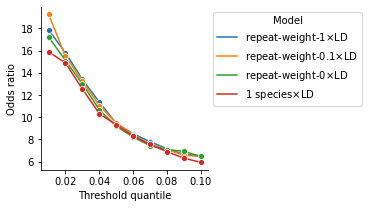

In [81]:
plt.figure(figsize=(3,3))
g = sns.lineplot(
    data=results[results.significant],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    #hue_order=[r"GPN$\times$LD", r"phyloP$\times$LD", r"phastCons$\times$LD"],#, "LD Score"],
    #style="significant",
    #style_order=[True, False],
    marker="o",
)
#g.axhline(1, ls='--', color="grey")
sns.despine();
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
#g.set(xscale='log');
#plt.savefig("output/plots/vep_gwas_line.pdf", bbox_inches='tight')

In [32]:
plt.figure(figsize=(3,3))
g = sns.lineplot(
    data=results_subset[results_subset.significant],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    #hue_order=[r"GPN$\times$LD", r"phyloP$\times$LD", r"phastCons$\times$LD"],#, "LD Score"],
    #style="significant",
    #style_order=[True, False],
    marker="o",
)
g.axhline(1, ls='--', color="grey")
sns.despine();
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
#g.set(xscale='log');
#plt.savefig("output/plots/vep_gwas_line.pdf", bbox_inches='tight')

NameError: name 'results_subset' is not defined

<Figure size 216x216 with 0 Axes>

In [ ]:
plt.figure(figsize=(2,2))

g = sns.barplot(
    data=results_subset[(results_subset.p_value<=0.05)&(results_subset["Threshold quantile"]==1e-3)],#1e-2)],
    x="Model",
    y="Odds ratio",
    color="C0",
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
sns.despine();
g.set(ylim=(1));
plt.xlabel("")
#plt.savefig("output/plots/vep_gwas_bar.svg", bbox_inches='tight');
#plt.savefig("output/plots/vep_gwas_bar_repeat_weight.svg", bbox_inches='tight');
#plt.savefig("output/plots/vep_gwas_bar_n_species.svg", bbox_inches='tight');

## Interpreting specific associations

In [ ]:
top_phenotypes = full_aragwas["study.phenotype.name"].value_counts().head(10).index.values
full_aragwas.groupby(["study.phenotype.name", "overPermutation"]).size().loc[top_phenotypes]

In [ ]:
target_phenotype = "clim-tmax1"
target_gwas = full_aragwas[full_aragwas["study.phenotype.name"]==target_phenotype]
target_gwas.overPermutation.value_counts()

In [ ]:
variants["original_index"] = variants.index
variants_gwas = variants.drop(
    columns=["aragwas_score", "overBonferroni", "overPermutation","study.phenotype.name",]
).merge(target_gwas, how="inner", on=["chrom", "pos", "ref", "alt"]).set_index("original_index")
variants_gwas.overPermutation.value_counts()

In [ ]:
variants_gwas["GWAS hit"] = variants_gwas.overPermutation.replace({True: "Yes", False: "No"})
variants_gwas["Chromosome position"] = variants_gwas.pos

def plot_variants_profile(vs, scores, save_path=None):
    #plt.figure(figsize=(4,3))
    ld_with_target = LD[vs.sort_values(scores[0]).index.values[0]][:, vs.index.values].toarray().ravel().round(decimals=1)
    print(ld_with_target)
    ld_col = r"""$r^2$ w/ lowest
GPN score"""
    vs[ld_col] = ld_with_target
    
    vs = pd.melt(
        vs, ["chrom", "Chromosome position", "ref", "alt", "GWAS hit", ld_col], scores, "Model", "Score"
    )
    sns.set_style("darkgrid") # dark  # to show the high ld with contrast
    g = sns.relplot(
        data=vs, x="Chromosome position", y="Score",
        row="Model",
        #hue="GWAS hit", hue_order=[True, False], palette="Dark2",
        style="GWAS hit", style_order=["Yes", "No"], markers=["o", "X"], #markers=["X", "."],
        hue=ld_col, palette="viridis",
        #hue="GWAS hit", hue_order=["Yes", "No"], palette={"Yes": "g", "No": "r"},
        kind="scatter", facet_kws={'sharey': False, 'sharex': True},
        height=2,
        aspect=1.6,
        s=100,
    )
    g.map(lambda **kwargs: plt.axhline(y=0, color='grey', linestyle='--'))
    g.set_titles(col_template="", row_template="")
    for i, score in enumerate(scores):
        g.axes[i,0].set_ylabel(score)
    plt.subplots_adjust(hspace=0.1)
    #sns.move_legend(
    #    g, "lower center",
    #    bbox_to_anchor=(0.4, 0.9),
    #    ncol=2,
    #)
    
    #g.axhline(0, ls='--', color="grey")  # would need to map?
    #sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")

    
def plot_variant_profile(v, score, context=100, **kwargs):
    print(v.pos, context)
    vs = variants_gwas[
        (variants_gwas.pos >= v.pos-context) & (variants_gwas.pos <= v.pos+context)
    ]
    print(len(vs))
    plot_variants_profile(vs, score, **kwargs)
    

def plot_ld_nearby(v, context=100):
    vs = variants_gwas[
        (variants_gwas.pos >= v.pos-context) & (variants_gwas.pos <= v.pos+context)
    ]
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        pd.DataFrame(
            LD[vs.index.values][:, vs.index.values].todense(),
            index=vs.overPermutation, columns=vs.overPermutation
        ),
        square=True, xticklabels=True, yticklabels=True
    )

In [ ]:
def top_LD_with_variant(v, k=3):
    row = LD.getrow(v.name)
    values = row.data
    indices = row.indices
    top_indices = indices[np.argsort(-values)[:k]]
    return variants_gwas[variants_gwas.index.isin(top_indices)]

def LD_max_dist_with_variant(v, threshold=0.7):
    print(LD[v.name,v.name])
    row = LD.getrow(v.name)
    values = row.data
    indices = row.indices
    top_indices = indices[values>threshold]
    vs = variants_gwas[variants_gwas.index.isin(top_indices)]
    return (v.pos-vs.pos).abs().max()

In [ ]:
# could also specify that there's no long-range LD (using a threshold)
# there's a lot of long-range LD, to bear in mind
# maybe filter the aragwas first for this
# would maybe have to re-do the GWAS analysis to avoid long-range LD? (maybe using a subset of phenotypes)
# by using PC's?
# or maybe do the filtering of LD matrix based on a radius myself?
# unclear what causes LD, to be honest.
# or maybe just don't show the fine-mapping... if there's long range LD
# the rest of the analysis is still good

# climtmax-1 interesting examples:
# chrom           5
# pos      10360998
# ref             T
# alt             A
# Name: 432170, dtype: object

for _, v in variants_gwas.query('overPermutation').sort_values("GPN").head(30).iterrows():
    #print(v)
    #max_abs_dist = (v.pos - top_LD_with_variant(v, k=2).pos).abs().max()
    #print(max_abs_dist)
    if v.pos != 24505063: continue
    max_abs_dist = LD_max_dist_with_variant(v, 0.8)
    if np.isnan(max_abs_dist):
        print(v.name)
        raise Exception("debug")
    if max_abs_dist == 0 or max_abs_dist > 10_000:
        print("skipping")
        continue
    print(v)
    print(max_abs_dist)
    plot_variant_profile(v, ["GPN", r"GPN$\times$LD"], context=max_abs_dist+10)#, save_path="output/plots/gwas_example.svg")
    plt.show()
    plot_ld_nearby(v, context=max_abs_dist+10)
    plt.show()

In [ ]:
"""
chrom                             5
pos                        11531640
ref                               T
alt                               A
AC                               12
AN                             1686
consequence      intergenic_variant
AF                         0.007117
GPN                      -10.289432
phyloP                     0.472434
phastCons                 -0.000185
aragwas_score              7.353801
aragwas_hit                    True
bin_GPN                           0
bin_phyloP                       37
bin_phastCons                    44
""";

# inside repeat but close to small conserved region. will skip for now.
# could compare to reference repeat.
# could check if it's qtl in another database. issue is it depends on RNA-seq being
# right tissue, developmental stage, stress, etc.
# some nearby genes: AT5G31412, AT5G30360

In [ ]:
"""
chrom                             5
pos                        11535787
ref                               A
alt                               T
AC                               12
AN                             1674
consequence      intergenic_variant
AF                         0.007168
GPN                       -9.268337
phyloP                    -0.315622
phastCons                 -0.007427
aragwas_score              11.85641
aragwas_hit                    True
bin_GPN                           0
bin_phyloP                       17
bin_phastCons                    28
""";

# not in a repeat. only aligned with the 2 other arabidopsis species
# could try to understand if there's a motif there. also check the specific trait,
# see if it's related to the nearby gene
# motif here: seems like it's a strengthening of a binding site  (inside core motif)
# http://planttfdb.gao-lab.org/tf.php?sp=Ath&did=AT3G46640.1#bind_motif
# but if it's a strengthening then way would it receive a negative, instead of positive score
# maybe don't showcase this
# not a fine-mapping example

In [ ]:
"""
vs = variants[
    (variants.pos >= v.pos-1000) & (variants.pos <= v.pos+1000)
]
plt.figure(figsize=(10, 10))
sns.heatmap(
    pd.DataFrame(
        LD[vs.index.values][:, vs.index.values].todense(),
        index=vs.overPermutation, columns=vs.overPermutation
    ),
    square=True, xticklabels=True, yticklabels=True
)
""";

In [ ]:
"""
chrom                             5
pos                        12172178
ref                               G
alt                               C
AC                               10
AN                             2222
consequence      intergenic_variant
AF                           0.0045
GPN                       -9.151054
phyloP                    -0.281095
phastCons                 -0.061246
aragwas_score              11.85641
aragwas_hit                    True
bin_GPN                           0
bin_phyloP                       18
bin_phastCons                    17
""";

In [ ]:
"""
chrom                      5
pos                  7543675
ref                        C
alt                        A
AC                        24
AN                      2198
consequence      stop_gained
AF                  0.010919
GPN                -8.982161
phyloP             -1.372914
phastCons          -0.357317
aragwas_score      14.915038
aragwas_hit             True
bin_GPN                    0
bin_phyloP                 4
bin_phastCons             10
""";

# gene: AT5G22690
# pretty clear example, no other hits nearby:
# https://aragwas.1001genomes.org/#/gene/AT5G22690

In [ ]:
"""
chrom                             5
pos                        12894850
ref                               G
alt                               C
AC                                8
AN                             2146
consequence      intergenic_variant
AF                         0.003728
GPN                       -8.817844
phyloP                    -1.393114
phastCons                 -0.892624
aragwas_score              11.85641
aragwas_hit                    True
bin_GPN                           0
bin_phyloP                        4
bin_phastCons                     5
""";

# lies in a conserved region, could check TFBS motif
# e.g. here: http://plantregmap.gao-lab.org/binding_site_prediction.php
# or could just download their database of non-conserved TFBS prediction
# is predicted to bind this (make sure to put lowest threshold)
# http://planttfdb.gao-lab.org/tf.php?sp=Ath&did=AT3G27785.1#bind_motif
# be aware of reverse complement.
# it matches part of the core motif
# could also understand specific phenotype

In [ ]:
"""
chrom                         5
pos                    21174728
ref                           A
alt                           C
AC                           58
AN                         1854
consequence      intron_variant
AF                     0.031284
GPN                   -7.741788
phyloP                 -0.90847
phastCons             -0.007009
aragwas_score         16.127622
aragwas_hit                True
bin_GPN                       0
bin_phyloP                    7
bin_phastCons                29
""";

# interesting intron variant, could try check raw RNA-seq data coverage to see if a new splicing pattern
# was created. although this is first intron, which also regulates expression

In [ ]:
# overlaps a funtfbs, pretty weird conservation pattern though, would skip
#v = variants.query('pos==18920189').iloc[0]
#v